# Data project 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import ipywidgets as widgets
import os
import seaborn as sns

%load_ext autoreload
%autoreload 2

# local modules
import dataproject

In [4]:
inc = pd.read_excel('average_income.xlsx', skiprows=2)
inc.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,1987,1988,1989,1990,1991,1992,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,1 Disponibel indkomst (2+30-31-32-35),Mænd og kvinder i alt,Gennemsnit for alle personer (kr.),Hele landet,78135.0,82304.0,87011.0,90433.0,94633.0,97606.0,...,179308.0,195011.0,199057.0,204037.0,209655.0,214009.0,220185.0,223438.0,229875.0,235312.0
1,NaN,NaN,NaN,Landsdel Byen København,78012.0,82061.0,85804.0,88668.0,90999.0,93536.0,...,177821.0,191577.0,196833.0,200886.0,206286.0,212311.0,218440.0,223635.0,229793.0,237224.0
2,NaN,NaN,NaN,København,75356.0,79444.0,82895.0,85421.0,87445.0,89913.0,...,171951.0,184281.0,189182.0,192990.0,198131.0,204008.0,209991.0,215215.0,220945.0,228338.0
3,NaN,NaN,NaN,Frederiksberg,85428.0,89924.0,94626.0,98916.0,101730.0,104476.0,...,199731.0,219475.0,224754.0,230908.0,238371.0,245712.0,252988.0,258624.0,267820.0,276683.0
4,NaN,NaN,NaN,Dragør,97966.0,99867.0,106167.0,109441.0,115203.0,117473.0,...,217104.0,242929.0,261933.0,264648.0,270354.0,279821.0,289465.0,295922.0,303980.0,311793.0
5,NaN,NaN,NaN,Tårnby,87598.0,90789.0,95053.0,98313.0,101982.0,104841.0,...,189340.0,203459.0,209500.0,212671.0,217423.0,222582.0,227877.0,232591.0,239104.0,245993.0
6,NaN,NaN,NaN,Landsdel Københavns omegn,88939.0,92579.0,96995.0,100005.0,103882.0,107099.0,...,199095.0,218907.0,225103.0,230320.0,236677.0,244283.0,256174.0,255631.0,260813.0,266919.0
7,NaN,NaN,NaN,Albertslund,83540.0,87075.0,90616.0,93620.0,96601.0,99553.0,...,172800.0,183831.0,182828.0,186626.0,188093.0,192715.0,196771.0,199705.0,202561.0,208399.0
8,NaN,NaN,NaN,Ballerup,86399.0,89122.0,93381.0,96440.0,99607.0,102596.0,...,183351.0,197401.0,202452.0,206484.0,210474.0,219824.0,223323.0,225245.0,230366.0,236121.0
9,NaN,NaN,NaN,Brøndby,83594.0,86917.0,91158.0,94147.0,97360.0,99990.0,...,171557.0,182312.0,185604.0,187577.0,190532.0,193785.0,197052.0,201440.0,205179.0,211029.0


To properly analyse the data we need to clean it from all unnecessary inputs like empty cells and "totals", which occurs due to different formatting in python and the given datasource we choose. 
The income data from Danmarks Statistik is plottet in an interactive figure with a slicing option for municipalities.

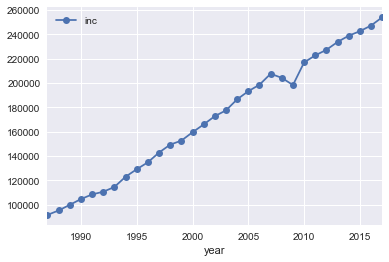

In [5]:
# a. clean and rename
inc.drop([f'Unnamed: {i}' for i in range(3)], axis=1, inplace=True)
inc.rename(columns = {'Unnamed: 3':'municipality'}, inplace=True)
inc.rename(columns = {str(i): f'inc{i}' for i in range(1987,2018)}, inplace=True)
inc.drop(inc.tail(2).index, inplace=True) # Delete last 2 rows

# b. remove regions
I = inc.municipality.str.contains('Landsdel', 'Hele landet')
inc.loc[I, :]
inc = inc.loc[I == False] # Keeps everything besides region

# c. change to long format
inc_tall = pd.wide_to_long(inc, stubnames='inc', i='municipality', j='year')
inc_tall = inc_tall.reset_index()

# d. create interactive figure
def plot_e(dataframe, municipality):
    I = dataframe['municipality'] == municipality
    ax=dataframe.loc[I,:].plot(x='year', y='inc', style='-o', legend='False')

widgets.interact(plot_e, 
    dataframe = widgets.fixed(inc_tall), 
    municipality = widgets.Dropdown(description='municipality', options=inc_tall.municipality.unique(), value='Greve')
);

For our further analysis we choose to look at the 5 municipalities with the larges and smallest income over the periode. Hence, we remove all other municipalities from the dataset by conditioning on the income size. 

In [6]:
# a. Find mean throughout entire period
inc_mean = inc_tall.groupby('municipality')['inc'].agg(lambda x: x.mean())
inc_mean.name = 'Average_income'

# b. Add average income to dataframe
inc_ = inc_tall.set_index('municipality').join(inc_mean, how='left')
inc_

# c. Filter the data to contain just year == 2018
inc_2017 = inc_[inc_.year==2017]

# d. Find 5 smallest and largest
smallest = inc_2017.nsmallest(5, 'Average_income')
largest = inc_2017.nlargest(5, 'Average_income')

# e. remove all besides the 10 municipalities
indexnames = inc_[ (inc_['Average_income'] >= 133700) & (inc_['Average_income'] <= 191600) ].index
inc_.drop(indexnames, inplace=True)

In [7]:
inc_.reset_index(inplace=True)
inc_['diff'] = inc_.inc - inc_.Average_income
inc_.reset_index(inplace=True)

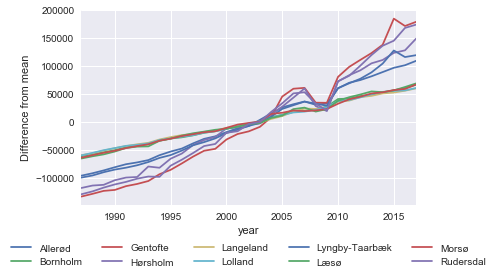

In [8]:
fig = plt.figure()
ax = plt.subplot(111)
inc_.set_index('year').groupby('municipality')['diff'].plot(kind='line', legend=True, ax=ax);
ax.set_ylabel('Difference from mean')
box = ax.get_position() # find plot coordinates 
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9]) # shrink height by 10% at bottom 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=5); # Put a legend below current axis

The plot shows the 10 municipalities difference from their mean over the periode. This is obviously affected by inflation. However, there is a clear difference in the trend for the 5 richest and 5 poorest municipalities. 

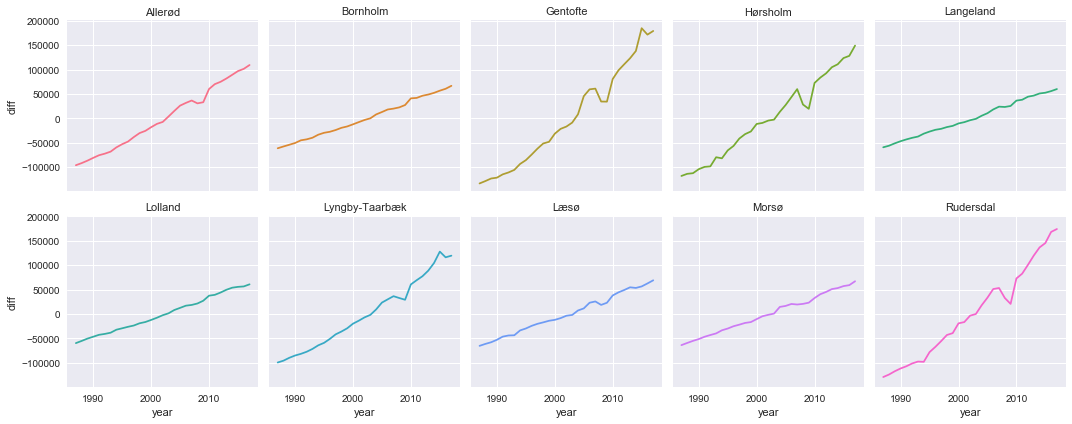

In [9]:
by_var = 'municipality'
y_var = 'diff'

g = sns.FacetGrid(inc_, col=by_var, hue=by_var, col_wrap=5)
g = g.map(plt.plot, 'year', y_var) # draw the upper line
#g = g.map(plt.fill_between, 'year', y_var, alpha=0.2).set_titles('{col_name}' +by_var)
g = g.set_titles('{col_name}')

In order to show the development more clearly in the plot, we have devided them into 10 seperate plots. For the 5 richest municiplaities, it is clear, that the financial crisis had a more significant impact on the income level. This might be due to larger stock positions, since more wealther people tend to have larger positions of securities. 

# Analysis

# Conclusion